In [1]:
import numpy as np 
import tensorflow as tf 
import os 
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from tensorflow.keras import layers, utils
from tqdm import tqdm
from skimage.measure import block_reduce
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

In [2]:
def siren_model(n_neurons=128,n_layers=3):
    # create model
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(n_neurons, input_shape=(6,), activation=tf.math.sin))
    for i in range(n_layers):
        model.add(tf.keras.layers.Dense(n_neurons, activation=tf.math.sin))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    # Compile model
    model.compile(loss='mse', optimizer='Adam')
    return model

def log_1px_transform(x):
    # log(x+1) transform to prevent log from exploding!
    return np.log(1+x)

def rejection_sampling(c_sqw, n_samples = 25000, filter_size=3):
    
    np.random.seed(47)
    
    Gaussian = cv2.GaussianBlur(c_sqw.T, (filter_size, filter_size), 0)
    #Gaussian[Gaussian < 0] = 0
    
    Z = np.sum(Gaussian)
    p_true = Gaussian/Z
    
    uniform_discrete = np.ones(c_sqw.T.shape)
    uniform_discrete = uniform_discrete/np.sum(uniform_discrete)
    
    C = np.max(p_true)/np.max(uniform_discrete)
    sampled = np.zeros(c_sqw.T.shape)
    for i in range(n_samples):
        idx = np.random.randint(p_true.shape)

        u = np.random.rand()
        fx = p_true[idx[0]][idx[1]]
        gx = uniform_discrete[idx[0]][idx[1]]

        if u  < fx/(C * gx):
            sampled[idx[0]][idx[1]] += 1
            
    return sampled

import tensorflow as tf
import tensorflow_probability as tfp
def correlation_loss(y_true, y_pred):
    y_true_flat = layers.Flatten(name="Y_TRUE_FLAT")(y_true)
    y_pred_flat = layers.Flatten(name="Y_PRED_FLAT")(y_pred)
    cov =  tfp.stats.covariance(y_true_flat, y_pred_flat, sample_axis=0, event_axis=None, name="COVARIANCE")
    std_y_trueR = tfp.stats.stddev(y_true_flat, sample_axis=0, keepdims=False, name="LOSS_STD_TRUE")
    std_y_predR = tfp.stats.stddev(y_pred_flat, sample_axis=0, keepdims=False, name="LOSS_STD_PRED")
    corr = tf.math.divide(cov,tf.math.multiply(std_y_trueR,std_y_predR, name="MULT_STDs"), name="CORRELATION")
    loss = tf.math.subtract(1.0,corr[0], name="CORR_LOSS")
    return loss


In [3]:
data = np.load('paper_data_code/neural_quantum_data2.npz')

In [4]:
X_train = data['train_x']
X_valid = data['valid_x']
X_test = data['test_x']

y_train = log_1px_transform(data['train_y'])
y_valid = log_1px_transform(data['valid_y'])
y_test = log_1px_transform(data['test_y'])

In [5]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

print(y_train.shape)
print(y_valid.shape)
print(y_test.shape)

(31944800, 6)
(1547600, 6)
(1547600, 6)
(31944800,)
(1547600,)
(1547600,)


In [6]:
from scipy.signal import savgol_filter

def generate_background(c_sqw, start, end):
    bkg = np.mean(c_sqw.T[:,start:end],axis=1)
    yhat = savgol_filter(bkg, 51, 3) # window size 51, polynomial order 3
    BKG = (np.expand_dims(yhat,axis=-1) * np.expand_dims(np.ones(c_sqw.shape[0]),axis=0)).T
    return BKG

def path2mesh(path):
    mesh = [] 

    c_q = np.array(pd.read_csv(os.path.join(path, 'Klist_' + str(k) + '.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_' + str(k) + '.csv'), header=None)).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_withBroadening_' + str(k) + '.csv'), header=None)).T

    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            mesh.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            
    return mesh 

def path2mesh_expt(j1, j2, model, path,path_num=2):
    mesh = [] 

    c_q = np.array(pd.read_csv(os.path.join(path, 'Qlist_path' + str(path_num) + '_woBG.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_path' + str(path_num) + '_woBG.csv'), header=None)[0]).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path' + str(path_num) + '_woBG.csv'), header=None)).T
    
    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            mesh.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            
    x = np.array(mesh)
    j1v = np.expand_dims(j1 * np.ones(len(x)),axis=-1)
    j2v = np.expand_dims(j2 * np.ones(len(x)),axis=-1)
    
    x = np.hstack((x,j1v))
    x = np.hstack((x,j2v))

    y_pred = model.predict(x)
   
    y_img = np.reshape(y_pred, (c_sqw.T).shape)

    return y_img 


## Test Data

In [7]:
model = tf.keras.models.load_model('model_siren_ebroaden')
path = '../data_test'

  0%|          | 0/15 [00:00<?, ?it/s]

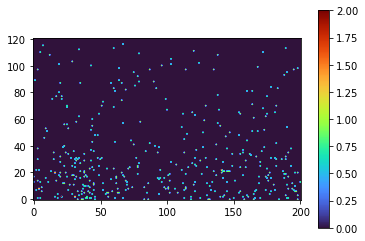

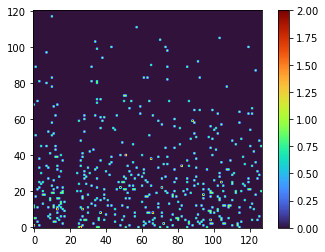

  7%|▋         | 1/15 [00:00<00:10,  1.40it/s]

Number of neutrons:  893.0


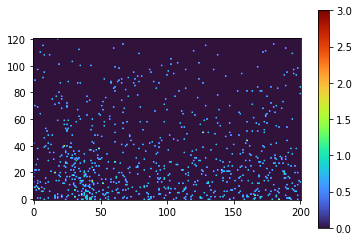

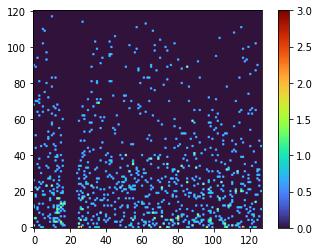

 13%|█▎        | 2/15 [00:01<00:11,  1.17it/s]

Number of neutrons:  1799.0


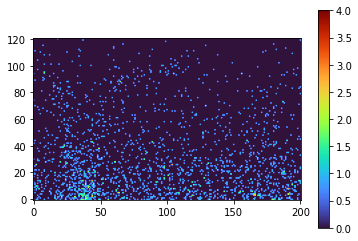

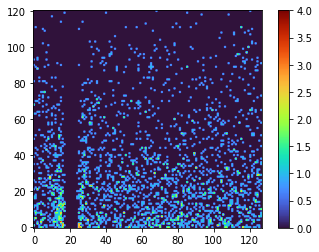

 20%|██        | 3/15 [00:03<00:16,  1.41s/it]

Number of neutrons:  4401.0


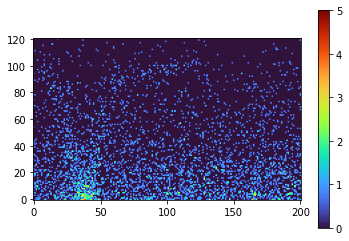

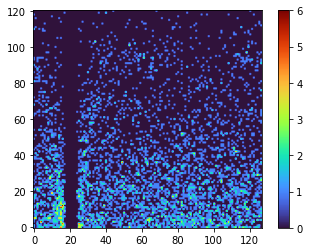

 27%|██▋       | 4/15 [00:06<00:23,  2.12s/it]

Number of neutrons:  8814.0


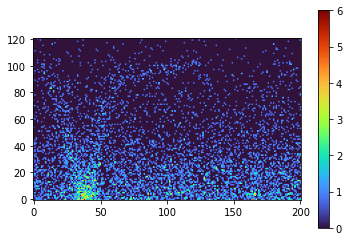

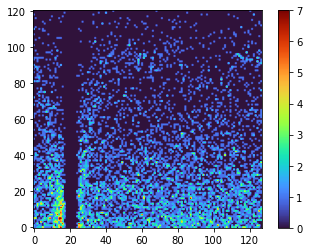

 33%|███▎      | 5/15 [00:11<00:30,  3.03s/it]

Number of neutrons:  13285.0


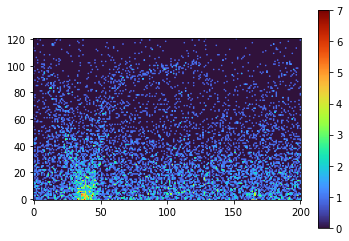

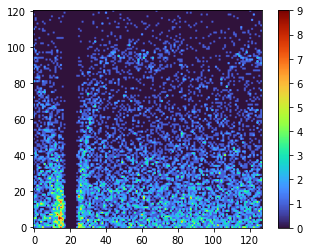

 40%|████      | 6/15 [00:17<00:36,  4.08s/it]

Number of neutrons:  17771.0


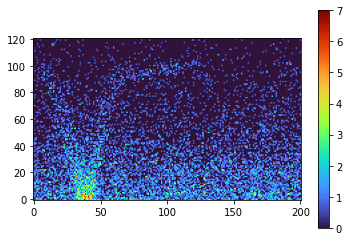

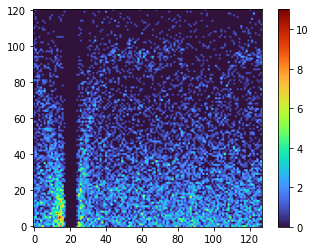

 47%|████▋     | 7/15 [00:24<00:40,  5.01s/it]

Number of neutrons:  20485.0


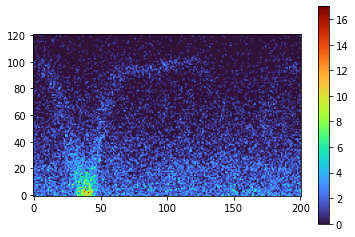

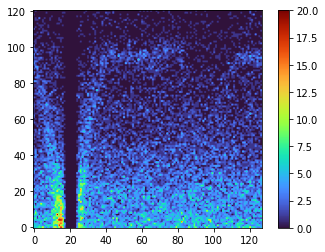

 53%|█████▎    | 8/15 [00:39<00:56,  8.10s/it]

Number of neutrons:  44697.0


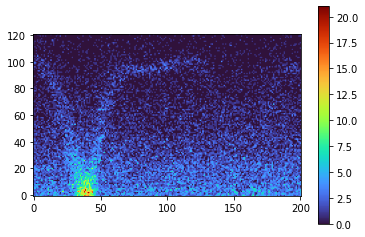

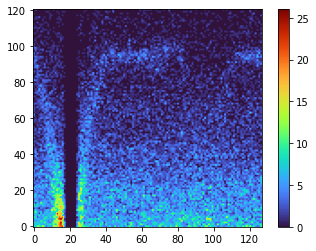

 60%|██████    | 9/15 [00:59<01:12, 12.02s/it]

Number of neutrons:  62703.0


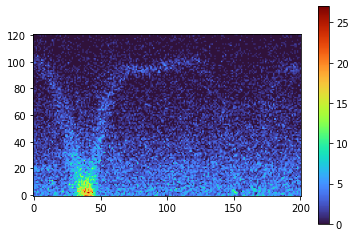

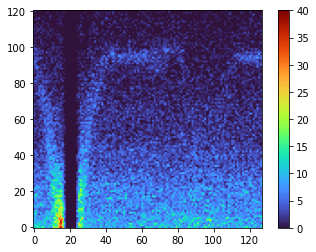

 67%|██████▋   | 10/15 [01:29<01:27, 17.45s/it]

Number of neutrons:  89700.0


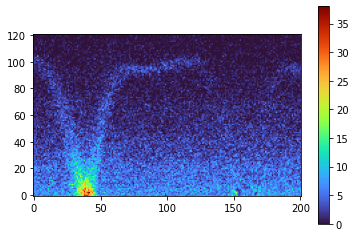

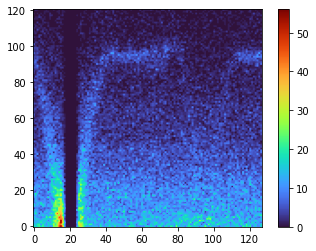

 73%|███████▎  | 11/15 [02:14<01:42, 25.74s/it]

Number of neutrons:  134537.0


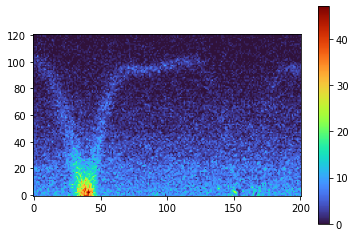

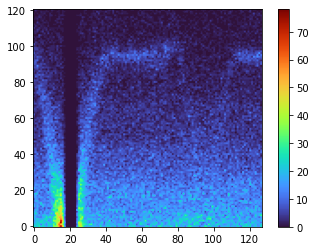

 80%|████████  | 12/15 [03:13<01:47, 35.89s/it]

Number of neutrons:  179233.0


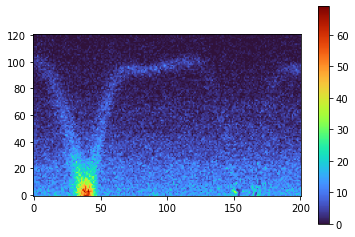

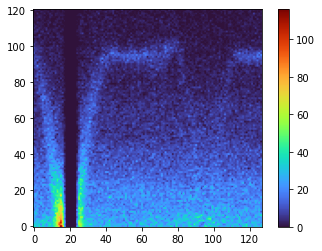

 87%|████████▋ | 13/15 [04:41<01:43, 51.68s/it]

Number of neutrons:  268659.0


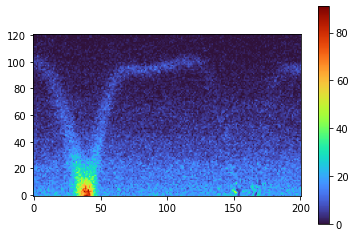

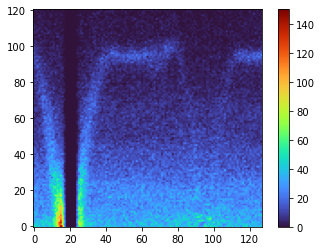

 93%|█████████▎| 14/15 [06:39<01:11, 71.81s/it]

Number of neutrons:  358524.0


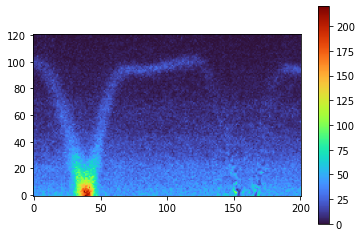

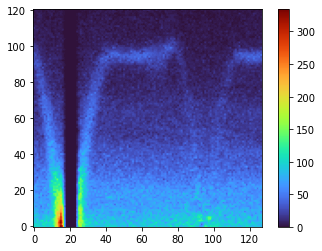

100%|██████████| 15/15 [11:35<00:00, 46.36s/it] 

Number of neutrons:  895806.0


In [10]:
num_neutrons = [] 
preds = [] 
    
for n_samples in tqdm([5000, 10000, 25000, 50000, 75000, 100000, 115000, 250000, 350000, 500000, 750000, 1000000,1500000, 2000000,5000000]):

    test_x_1 = []
    test_y_1 = [] 

    c_q = np.array(pd.read_csv(os.path.join(path, 'Qlist_path2_woBG.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_path2_woBG.csv'), header=None)[0]).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path2.csv'), header=None)).T
    
    
    c_sqw_rs = rejection_sampling(c_sqw, n_samples=n_samples).T
    
    plt.imshow(c_sqw_rs.T, origin='lower', cmap='turbo')  
    plt.colorbar()
    plt.show()
    
    diff = generate_background(c_sqw_rs, 150, 160)
    
    n_1 = np.sum(c_sqw_rs)
    
    c_sqw = (c_sqw_rs.T - diff.T).T
    
    #c_sqw[c_sqw < 0] = 0
    
#     plt.imshow(diff.T, origin='lower')
#     plt.show()
             

     
    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            test_x_1.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            test_y_1.append(c_sqw[i,j])

    test_x_1 = np.array(test_x_1) 
    test_y_1 = np.array(test_y_1)

    test_x_2= []
    test_y_2= [] 
    weight_2 = [] 

    c_q = np.array(pd.read_csv(os.path.join(path, 'Qlist_path3_woBG.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_path3_woBG.csv'), header=None)[0]).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path3.csv'), header=None)).T
    c_err = np.array(pd.read_csv(os.path.join(path, 'Err_path3.csv'), header=None)).T
    
    c_sqw_rs = rejection_sampling(c_sqw, n_samples=n_samples).T
    
    plt.imshow(c_sqw_rs.T, origin='lower', cmap='turbo')  
    plt.colorbar()
    plt.show()
    
    diff = generate_background(c_sqw_rs, 95, 100)
    n_2 = np.sum(c_sqw_rs)
    
    #scale_factor = np.sum(c_sqw_rs)/np.sum(diff)
    #c_sqw = (c_sqw_rs.T - (scale_factor)*diff.T).T
    c_sqw = (c_sqw_rs.T - diff.T).T
    #c_sqw[c_sqw < 0] = 0
    
    print('Number of neutrons: ', n_1 + n_2)
    
    continue 
    
#     plt.imshow(diff.T, origin='lower')
#     plt.show()
    
    # plt.imshow(c_sqw.T, origin='lower', cmap='turbo')  
    # plt.colorbar()
    # plt.show()

    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            test_x_2.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            test_y_2.append(c_sqw[i,j])
            #weight_2.append(c_err[i,j])
    test_x_2 = np.array(test_x_2) 
    test_y_2 = np.array(test_y_2)
    #weight_2 = np.array(weight_2)
    
    num_neutrons.append([n_1 + n_2])
    #####################################
    
    
    
    batch_size = 2048
    max_iter = 2000
    learning_rate = 0.01
    
    test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)
    test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)

    loss_vals = [] 
    
    # Adam optimizer 
    opt = tf.optimizers.Adam(learning_rate)
    
    # MSE loss function
    #loss_fn = correlation_coefficient()
    
    pred_iter = [] 
    for n_opts in range(10):
        metrics = [] 
        
        j1 = tf.Variable(tf.random.uniform(shape=[1],minval=-0.5,maxval=0.5), constraint=lambda t: tf.clip_by_value(t, -0.5, 0.5))
        j2 = tf.Variable(tf.random.uniform(shape=[1],minval=0.0,maxval=1.5), constraint=lambda t: tf.clip_by_value(t, 0.0, 1.5))

        for i in range(max_iter):

            ones_vector = tf.ones(test_x.shape[0])

            with tf.GradientTape() as tape:

                tape.watch(j1)
                tape.watch(j2)

                j1_vector = tf.expand_dims(j1 * ones_vector,axis=-1)
                j2_vector = tf.expand_dims(j2 * ones_vector,axis=-1)

                # forward model 
                x_in = tf.concat((test_x, j1_vector, j2_vector),axis=1)
                ridxs = tf.convert_to_tensor(np.random.choice(np.arange(0, len(x_in)), batch_size))
                x_in_batch = tf.gather(x_in, ridxs)

                y_pred_batch =  model(x_in_batch)
                test_y_batch = tf.math.log(tf.clip_by_value(tf.gather(test_y, ridxs),0,10000) + 1)


                #weights_batch = tf.gather(error_weights, ridxs)
                #weights = test_y_batch

                #loss = weighted_correlation_loss(test_y_batch, y_pred_batch, weights)
                loss = correlation_loss(y_pred_batch, test_y_batch)
                #loss =  weighted_mse(test_y_batch, y_pred_batch, weights)

            # Take derivative of surrogate model w.r.t j1, j2 
            gradients = tape.gradient(loss, [j1, j2])
            opt.apply_gradients(zip(gradients, [j1, j2]))

            metrics.append([float(loss), float(j1), float(j2)])

#         plt.plot(np.arange(0,max_iter), 1 - np.array(metrics)[:,0], alpha=0.9)
#         plt.xlabel("Number of Iterations")
#         plt.ylabel("Correlation function")
#         plt.show()

#         plt.plot(np.arange(0,max_iter), np.array(metrics)[:,1], alpha=0.9)
#         plt.xlabel("Number of Iterations")
#         plt.ylabel("J1")
#         plt.show()

#         plt.plot(np.arange(0,max_iter), np.array(metrics)[:,2], alpha=0.9)
#         plt.xlabel("Number of Iterations")
#         plt.ylabel("J2")
#         plt.show()

        min_loss, min_loss_j1, min_loss_j2 = np.array(metrics)[np.argmin(np.array(metrics)[:,0])]
        pred_iter.append([min_loss_j1, min_loss_j2])
        
    
    print("number of neutrons: ", n_1 + n_2, "Median prediction: ", np.median(pred_iter,axis=0))

    preds.append(pred_iter)
     

In [1]:
j1

NameError: name 'j1' is not defined

In [55]:
np.save('predictions_low_count', preds)
np.save('neutrons_low_count', num_neutrons)

In [42]:
num_neutrons = np.array(num_neutrons)
preds = np.array(preds)


In [54]:
num_neutrons.shape

(15, 1)

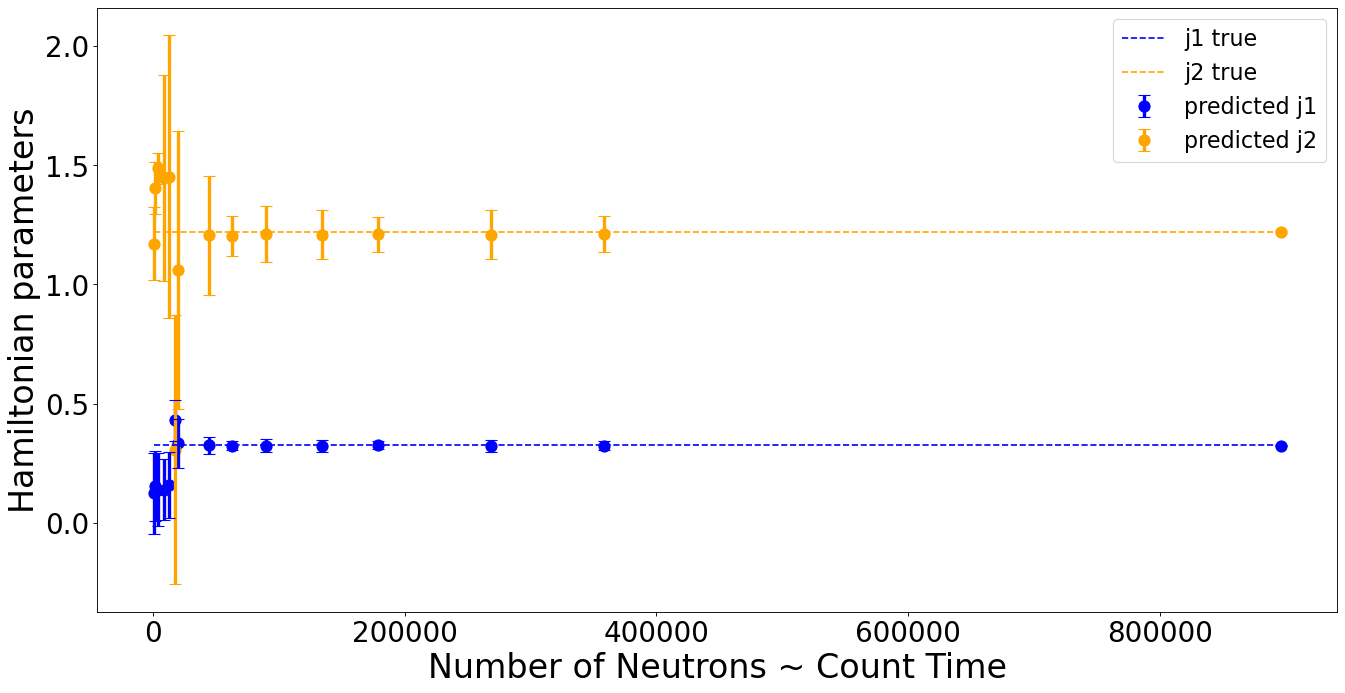

In [87]:
from matplotlib.pyplot import figure

figure(figsize=(20, 10), dpi=80)

#plt.scatter(num_neutrons, preds[:,0,0])
#plt.scatter(num_neutrons, preds[:,0,1])

plt.errorbar(num_neutrons, np.median(preds[:,:,0],axis=1), np.std(preds[:,:,0],axis=1), fmt = 'o', ms = 10, elinewidth=3, capsize=5, barsabove=True, label = 'predicted j1', color = 'blue')
plt.errorbar(num_neutrons, np.median(preds[:,:,1],axis=1), np.std(preds[:,:,1],axis=1), fmt = 'o', ms = 10, elinewidth=3, capsize=5, barsabove=True, label = 'predicted j2', color = 'orange')
plt.plot(num_neutrons, 0.328*np.ones(num_neutrons.shape), "--", label = 'j1 true', color = 'blue')
plt.plot(num_neutrons, 1.2198*np.ones(num_neutrons.shape), "--", label = 'j2 true',  color = 'orange')
plt.xticks(fontsize = 25)
plt.yticks(fontsize = 25)
plt.xlabel('Number of Neutrons ~ Count Time', fontsize = 30)
plt.ylabel('Hamiltonian parameters', fontsize = 30)
#plt.xscale('log')
plt.legend(fontsize=20)
plt.show()

In [15]:
np.sum(c_sqw_rs)

100140.0

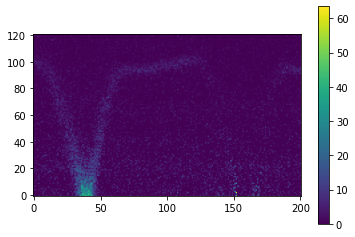

In [24]:
c_sqw[c_sqw < 0] = 0 

plt.imshow(c_sqw.T, origin='lower')  
plt.colorbar()
plt.show()

In [40]:
test_x_1 = np.array(test_x_1) 
test_y_1 = np.array(test_y_1)

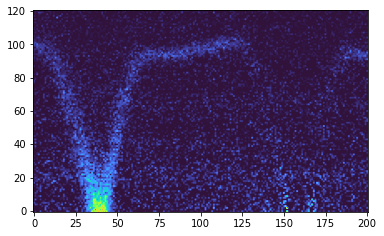

In [25]:
plt.imshow(c_sqw.T, origin='lower', cmap='turbo')

<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([0.23946252], dtype=float32)>
<tf.Variable 'Variable:0' shape=(1,) dtype=float32, numpy=array([1.2704217], dtype=float32)>


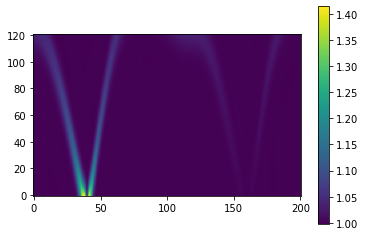

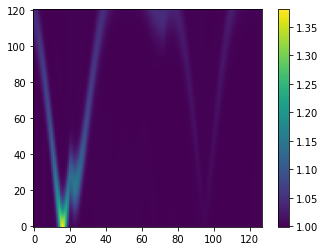

In [68]:
min_loss, min_loss_j1, min_loss_j2 = metrics[np.argmin(metrics[:,0])]
print(j1)
print(j2)
noise_std = 0.001
for i in [2,3]:
    path = '../data_test/'
    
    y_img = path2mesh_expt(float(j1), float(j2), model, path, path_num=i)
    #c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path' + str(i) + '_woBG.csv'), header=None)).T
    #c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path' + str(i) + '.csv'), header=None)).T
    #c_sqw += np.random.poisson(1, c_sqw.shape)
    #np.random.normal(0, noise_std, c_sqw.shape)
    
    #c_sqw = sampled.T
    #c_sqw[c_sqw < 0] = 0 
    #break
    
    #plt.imshow((np.log(c_sqw.T+1)), origin='lower') 
    #plt.colorbar()
    #plt.show()
    
    plt.imshow(np.exp(y_img), origin='lower') 
    plt.colorbar()
    plt.show()



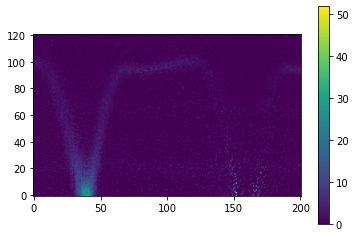

In [378]:
plt.imshow(c_sqw.T, origin='lower')
plt.colorbar()


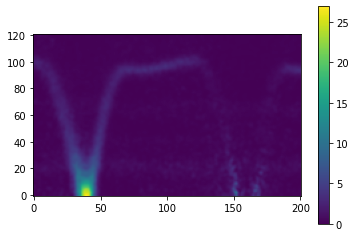

In [379]:
import cv2
import numpy as np

# Gaussian Blur
#Gaussian = cv2.GaussianBlur(c_sqw.T, (3, 3), 0)

Gaussian = cv2.GaussianBlur(c_sqw.T, (5, 5), 0)

Gaussian[Gaussian < 0] = 0
plt.imshow(Gaussian, origin='lower')
plt.colorbar()
plt.show()

In [349]:
np.min(Gaussian)

0.0

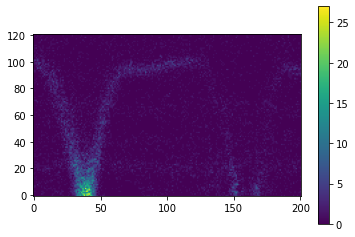

In [383]:
plt.imshow(sampled, origin='lower')
plt.colorbar()

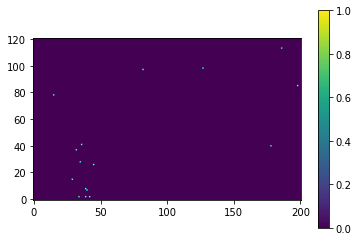

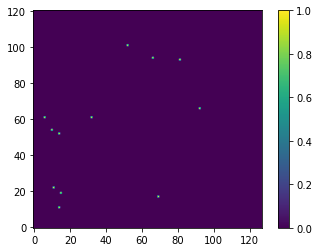

(127, 121)


100%|██████████| 1000/1000 [00:13<00:00, 72.09it/s]


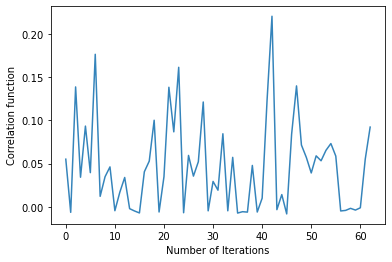

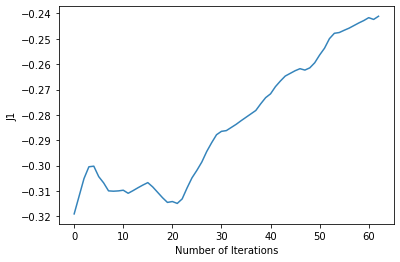

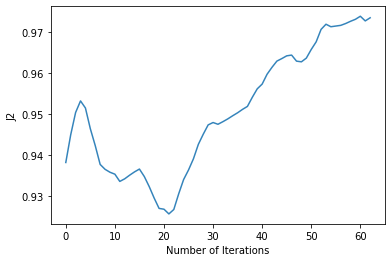

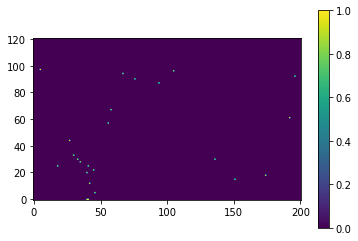

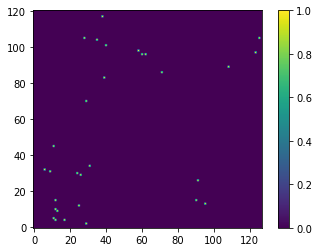

(127, 121)


100%|██████████| 1000/1000 [00:11<00:00, 85.35it/s]


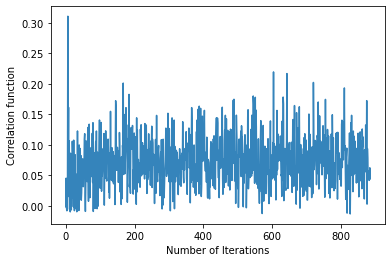

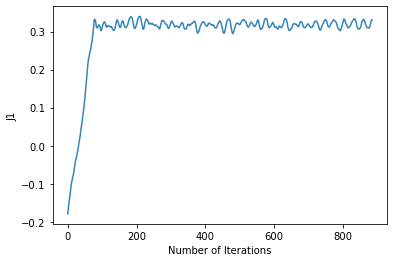

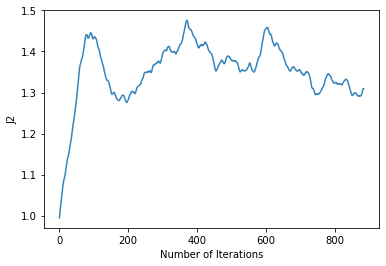

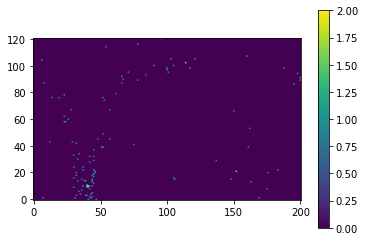

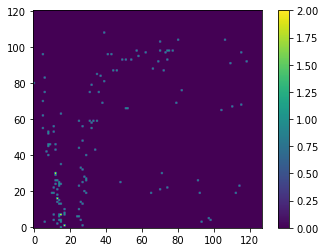

(127, 121)


 18%|█▊        | 179/1000 [00:02<00:09, 84.55it/s]

In [ ]:
from numpy import genfromtxt
import cv2
    
noise_std = 10
pred_j1j2 = [] 

for count_rate in [500, 1000, 5000, 10000, 20000, 50000, 100000, 500000, 1000000]:
    
    path = '../data_test/' # path to broadened data 

    test_x_1 = []
    test_y_1 = [] 
    weight_1 = []

    c_q = np.array(pd.read_csv(os.path.join(path, 'Qlist_path2_woBG.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_path2_woBG.csv'), header=None)[0]).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path2_woBG.csv'), header=None)).T
    c_err = np.array(pd.read_csv(os.path.join(path, 'Err_path2_step_number.csv'), header=None)).T

    c_sqw = rejection_sampling(c_sqw, n_samples=count_rate).T

    plt.imshow(c_sqw.T, origin='lower')  
    plt.imshow((c_sqw.T), origin = 'lower')
    plt.colorbar()
    plt.show()

    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            test_x_1.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            test_y_1.append(c_sqw[i,j])
            weight_1.append(c_err[i,j])
    test_x_1 = np.array(test_x_1) 
    test_y_1 = np.array(test_y_1)
    weight_1 = np.array(weight_1)

    test_x_2= []
    test_y_2= [] 
    weight_2 = [] 

    c_q = np.array(pd.read_csv(os.path.join(path, 'Qlist_path3_woBG.csv'), header=None)).T
    c_E = np.array(pd.read_csv(os.path.join(path, 'Elist_path3_woBG.csv'), header=None)[0]).T
    c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path3_woBG.csv'), header=None)).T
    c_err = np.array(pd.read_csv(os.path.join(path, 'Err_path3.csv'), header=None)).T

    c_sqw = rejection_sampling(c_sqw, n_samples=count_rate).T

    #_sqw = (c_sqw - np.min(c_sqw))/(np.max(c_sqw) - np.min(c_sqw))
    #c_sqw[c_sqw < 0] = 0
    plt.imshow((c_sqw.T),origin = 'lower')
    plt.colorbar()
    plt.show()

    print(c_sqw.shape)

    for j in range(c_sqw.shape[1]):
        for i in range(c_sqw.shape[0]):
            test_x_2.append([c_q[i][0], c_q[i][1], c_q[i][2], float(c_E[j])/200])
            test_y_2.append(c_sqw[i,j])
            weight_2.append(c_err[i,j])
    test_x_2 = np.array(test_x_2) 
    test_y_2 = np.array(test_y_2)
    weight_2 = np.array(weight_2)


    batch_size = 4096
    max_iter = 1000
    learning_rate = 0.01
    test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)
    test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)
    error_weights = (1 / tf.convert_to_tensor(np.concatenate((weight_1, weight_2)), dtype=tf.float32)) ** 2

    #test_x = tf.convert_to_tensor(test_x_1, dtype=tf.float32)
    #test_y = tf.convert_to_tensor(test_y_1, dtype=tf.float32)
    #error_weights = (1 / tf.convert_to_tensor(weight_1, dtype=tf.float32))**2

    #test_y += np.random.poisson(noise_std, test_y.shape)

    loss_vals = [] 

    metrics = [] 
    # Adam optimizer 
    opt = tf.optimizers.Adam(learning_rate)

    # MSE loss function
    #loss_fn = correlation_coefficient()

    j1 = tf.Variable(tf.random.uniform(shape=[1],minval=-0.5,maxval=0.5))
    j2 = tf.Variable(tf.random.uniform(shape=[1],minval=0.0,maxval=1.5))

    for i in tqdm(range(max_iter)):

        ones_vector = tf.ones(test_x.shape[0])

        with tf.GradientTape() as tape:

            tape.watch(j1)
            tape.watch(j2)

            j1_vector = tf.expand_dims(j1 * ones_vector,axis=-1)
            j2_vector = tf.expand_dims(j2 * ones_vector,axis=-1)

            # forward model 
            x_in = tf.concat((test_x, j1_vector, j2_vector),axis=1)
            ridxs = tf.convert_to_tensor(np.random.choice(np.arange(0, len(x_in)), batch_size))
            x_in_batch = tf.gather(x_in, ridxs)

            y_pred_batch =  model(x_in_batch)
            test_y_batch = tf.math.log(tf.clip_by_value(tf.gather(test_y, ridxs),0,10000) + 1)


            #weights_batch = tf.gather(error_weights, ridxs)
            #weights = test_y_batch

            #loss = weighted_correlation_loss(test_y_batch, y_pred_batch, weights)
            loss = correlation_loss(y_pred_batch, test_y_batch)
            #loss =  weighted_mse(test_y_batch, y_pred_batch, weights)

        # Take derivative of surrogate model w.r.t j1, j2 
        gradients = tape.gradient(loss, [j1, j2])
        opt.apply_gradients(zip(gradients, [j1, j2]))

        metrics.append([float(loss), float(j1), float(j2)])

    metrics = np.array(metrics)

    plt.plot(np.arange(0,max_iter), 1 - metrics[:,0], alpha=0.9)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Correlation function")
    plt.show()

    plt.plot(np.arange(0,max_iter), metrics[:,1], alpha=0.9)
    plt.xlabel("Number of Iterations")
    plt.ylabel("J1")
    plt.show()

    plt.plot(np.arange(0,max_iter), metrics[:,2], alpha=0.9)
    plt.xlabel("Number of Iterations")
    plt.ylabel("J2")
    plt.show()
    
    min_loss, min_loss_j1, min_loss_j2 = metrics[np.argmin(metrics[:,0])]
    
    pred_j1j2.append([float(min_loss_j1), float(min_loss_j2)])
    

In [433]:
pred_j1j2

[[0.32356616854667664, 1.1753278970718384],
 [0.31823205947875977, 1.1327099800109863]]

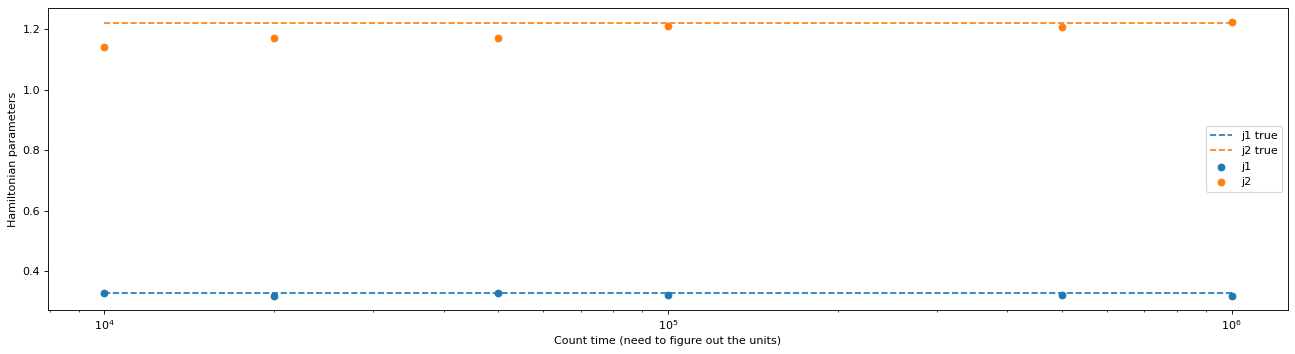

In [431]:
noises = np.array([10000, 20000, 50000, 100000, 500000, 1000000])
pred_j1j2 = np.array(pred_j1j2)
from matplotlib.pyplot import figure

figure(figsize=(20, 5), dpi=80)

plt.scatter(noises, pred_j1j2[:,0], label = 'j1')
plt.scatter(noises, pred_j1j2[:,1], label = 'j2')
plt.plot(noises, 0.328*np.ones(noises.shape), "--", label = 'j1 true')
plt.plot(noises, 1.2198*np.ones(noises.shape), "--", label = 'j2 true')
plt.xlabel('Count time (need to figure out the units)')
plt.ylabel('Hamiltonian parameters')
plt.xscale('log')
plt.legend()
plt.show()

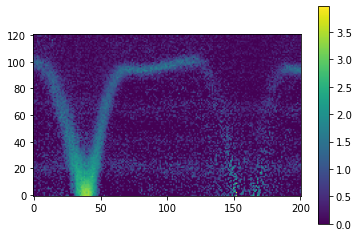

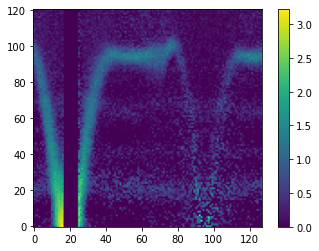

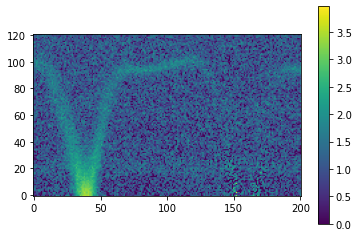

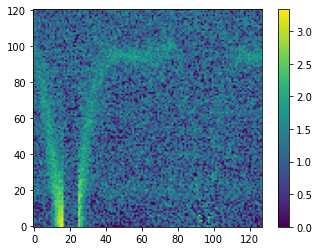

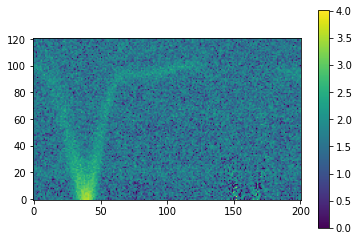

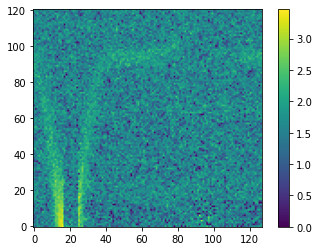

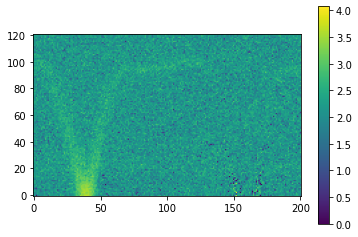

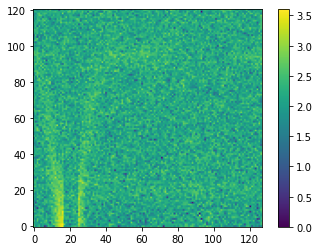

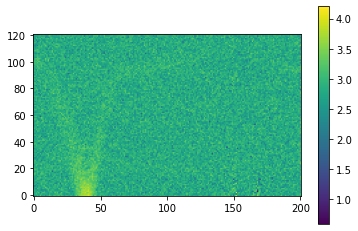

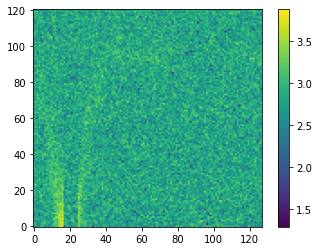

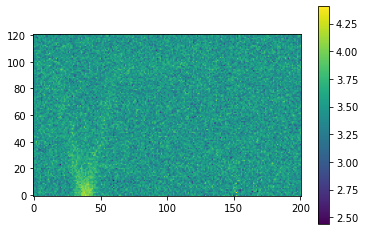

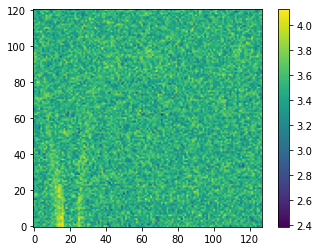

In [99]:
for noise_std in [0.00001, 2, 4, 8, 16, 32]:
    for i in [2,3]:
        path = '../data_test/'

        y_img = path2mesh_expt(float(j1), float(j2), model, path, path_num=i)
        c_sqw = np.array(pd.read_csv(os.path.join(path, 'Sqw_path' + str(i) + '_woBG.csv'), header=None)).T
        c_sqw += np.random.poisson(noise_std, c_sqw.shape)
        c_sqw[c_sqw < 0] = 0 

        plt.imshow((np.log(c_sqw.T+1)), origin='lower') 
        plt.colorbar()
        plt.show()


    

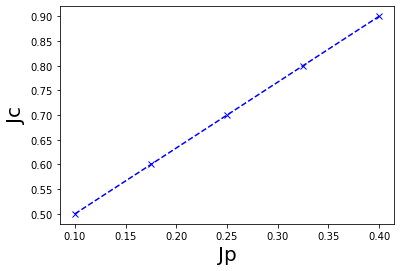

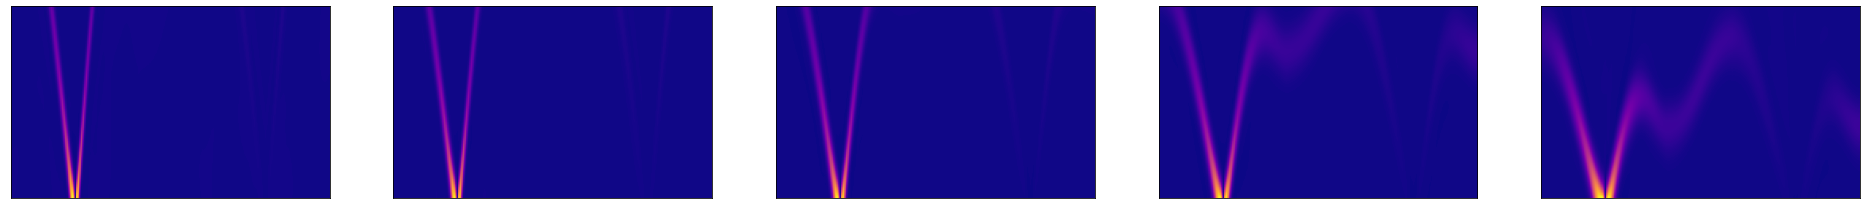

In [34]:
from matplotlib.colors import LogNorm

new_path = np.stack((np.linspace(0.1, 0.4, 5), np.linspace(0.5, 0.9, 5))).T

# plt.scatter(y_regression[:,0], y_regression[:,1], c='grey', alpha=0.5)
# plt.scatter(y_regression[idx][:,0], y_regression[idx][:,1], c='orange', alpha=1)
plt.plot(new_path[:,0], new_path[:,1], '--bx', alpha=1)
plt.xlabel('Jp', fontsize=20)
plt.ylabel('Jc', fontsize=20)
plt.show()

fig=plt.figure(figsize=(40,25))
columns = 6
rows = 1
i = 1
for jvector in new_path:
    j1 = jvector[0]
    j2 = jvector[1]
    
    y_img = path2mesh_expt(float(j1), float(j2), model, path, path_num=2)
    
    fig.add_subplot(rows, columns, i)
    
    plt.imshow(y_img, origin='lower', cmap='plasma') 
    #plt.arrow(
    plt.xticks([])
    plt.yticks([])
    i += 1 
               
plt.show()
    
    

# Loss landscape

In [38]:
test_x = tf.convert_to_tensor(np.vstack((test_x_1, test_x_2[test_y_2 != 0])), dtype=tf.float32)
test_y = tf.convert_to_tensor(np.concatenate((test_y_1, test_y_2[test_y_2 != 0])), dtype=tf.float32)
test_y = tf.math.log(tf.clip_by_value(test_y,0,10000) + 1)

loss_vals = []

# Define a uniform grid to evaluate loss function
j1 = np.linspace(-0.5, 0.5, 33)
j2 = np.linspace(0.0, 1.5, 33)
j1j1, j2j2 = np.meshgrid(j1,j2)
j1_all = np.ravel(j1j1)
j2_all = np.ravel(j2j2)

ones_vector = tf.ones(test_x.shape[0])

for i in tqdm(range(len(j1_all))):
    j1 = j1_all[i]
    j2 = j2_all[i]
    
    j1_vector = tf.expand_dims(j1 * ones_vector,axis=-1)
    j2_vector = tf.expand_dims(j2 * ones_vector,axis=-1)
        
    x_in = tf.concat((test_x, j1_vector, j2_vector),axis=1)
    y_pred = model.predict(x_in)
    
    loss = correlation_loss(test_y, y_pred)
    loss_vals.append([j1_all[i], j2_all[i], float(loss)])

loss_vals = np.array(loss_vals)
np.save('loss_landscape', loss_vals)

100%|██████████| 1089/1089 [28:49<00:00,  1.59s/it]


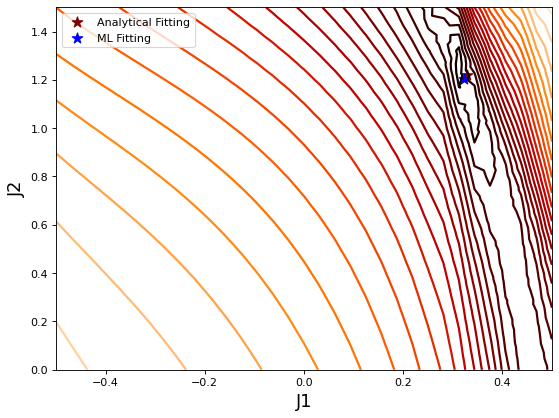

In [48]:
import matplotlib.tri as tri
import matplotlib.pyplot as plt
                                                           
plt.figure(figsize=(8, 6), dpi=80)
plt.tricontour(loss_vals[:,0], loss_vals[:,1], loss_vals[:,2], 21, linewidths=2.0, cmap='gist_heat')
plt.xlabel('J1', fontsize=16)
plt.ylabel('J2', fontsize=16)
plt.scatter([0.328], [1.2198], marker = '*', s=100, color = 'maroon', label = 'Analytical Fitting')
plt.scatter([0.32233572], [1.2052228], marker = '*', s=100, color = 'blue', label = 'ML Fitting')
plt.legend(loc='upper left')
plt.show()